## Spotify Analysis

#### Introduction
Music has always been important to me. I wondered if throughout the past 5 years, I preferred certain attributes in music or if I preferred a more diverse spread. I always thought of myself as "non-mainstream", listening to music fewer people listen to or seek out. 

In this project, I attempt to analyse my top 100 tracks of 2016, 2017, 2018 & 2019 based on multiple audio features, comparing it to Spotify's top 300 most streamed tracks.

#### Project Objectives:

- To gain insights on what song features determine what kind of music I listen to
- To compare my music preferences with the mainstream listeners on Spotify and establish if my preferences are as unique as I perceive them to be
- To explore if there is any correlation between the features of a track

#### Method
Data gathering was performed with Python. I utilized Spotipy, a lightweight Python library for the Spotify Web API. 

With Spotipy you get full access to all of the music data provided by the Spotify REST API.

I worked with five playlists:

- My own top 100 tracks of 2016, 2017, 2018 & 2019, provided by Spotify
- Spotify's top 300 most streamed tracks of all time

I retrieved the audio features for each track in these playlists, analysed them and plotted the distribution of the several features across the songs in each playlist, separated into my playlists and the top 300 most streamed songs.

I plotted the top 300 most streamed tracks of Spotify in green to easier contrast against my top tracks.

Some examples of audio features for the track Spotify provides (through their acquisition of EchoNest) include:

- Tempo
- Energy
- Danceability of a track etc.

At the end, I utilize random forests to predict if song features determine whether the track will end up being one of the Top 300 most streamed songs of all time on Spotify.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
import calendar
import re
import os

#import statements

In [4]:
client_id = os.environ.get('SPOTIFY_CLIENT_ID')
client_secret = os.environ.get('SPOTIFY_CLIENT_SECRET')

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

#auth credentials

In [5]:
ids = []
plist = []

def getPlaylistTrackIDs_v2(user, playlist_id):

    playlist = sp.user_playlist(user, playlist_id)['tracks']
    playlist_name = sp.user_playlist(user, playlist_id)['name']
    for x in playlist['items']:
        if x['track']['id']:
            ids.append(x['track']['id'])
            plist.append(playlist_name)
            while playlist['next']:
                playlist = sp.next(playlist)
                for y in playlist['items']:
                    if y['track']['id']:
                        ids.append(y['track']['id'])
                        plist.append(playlist_name)
                    else:
                        print("Error retrieving ID for the track: " + str(y['track']['name']))


    print("\n")
    print(f"Track IDs successfully extracted from playlist: {sp.user_playlist(user, playlist_id)['name']}")

    return ids
          
#Pagination problem solved!
          
#Included null checks for those that didn't have ID/Playlist Name (local files, removed local files)

In [6]:
ids = []
plist = []

all_playlist_ids = ["37i9dQZF1CyRtRL1Zwexck","37i9dQZF1E9Hx4FoPAsQBS","37i9dQZF1EjvNwqoQGlcgp",
                   "37i9dQZF1Etj8RlcIkkYNS","07BZwq6FrzVKceJx3GMt8n"]

for x in all_playlist_ids:
    getPlaylistTrackIDs_v2('11126364780', x)



Track IDs successfully extracted from playlist: Your Top Songs 2016


Track IDs successfully extracted from playlist: Your Top Songs 2017


Track IDs successfully extracted from playlist: Your Top Songs 2018


Track IDs successfully extracted from playlist: Your Top Songs 2019


Track IDs successfully extracted from playlist: Top 300 Most Streamed Songs Of All Time [Spotify]


In [7]:
def getTrackFeatures(id):
    meta = sp.track(id)
    features = sp.audio_features(id)
    
     # Meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']

    # Features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    time_signature = features[0]['time_signature']
    valence = features[0]['valence']

    track = [name, album, artist, release_date, length, popularity, danceability, acousticness, energy, instrumentalness, liveness, loudness, speechiness, tempo, time_signature, valence]
    return track

#function for extracting features from each track

In [8]:

tracks = []
for i in range(len(ids)):
        try:
            track = getTrackFeatures(ids[i])
            tracks.append(track)
        except:
            pass
        
        df = pd.DataFrame(tracks, columns = ['name', 'album', 'artist', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature', 'valence'])
        
# loop over track ids to create dataset in Pandas Dataframe

In [9]:
df['playlist'] = plist
df['release_date'] = pd.to_datetime(df['release_date'],format='%Y-%m-%d %H:%M:%S')
df['release_month'] = df['release_date'].apply(lambda x:x.month)
df['release_year'] = df['release_date'].apply(lambda x:x.year)
df['release_day'] = df['release_date'].apply(lambda x:x.day)
df['dayofweek']=df['release_date'].apply(lambda x:calendar.day_name[x.weekday()])

#appending playlist name + extra features 

In [10]:
df2 = df[df['playlist']!="Top 300 Most Streamed Songs Of All Time [Spotify]"]
df3 = df[df['playlist']=="Top 300 Most Streamed Songs Of All Time [Spotify]"]

sns.set_style('whitegrid')

#splitting into two different datasets to compare distributions for features

### Valence

A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive(e.g. happy, cheerful, euphoric), #while tracks with low valence sound more negative (e.g. sad, depressed, angry).

The valence distribution for my top 400 songs (2016,2017, 2018, 2019) seems to display a slightly lower average valence, signifying a preference for sadder songs.

However, Spotify's top 300 most streamed displays a higher average valence than my songs, indicating a preference for happier songs in general for the mainstream audience.

<AxesSubplot:xlabel='valence'>

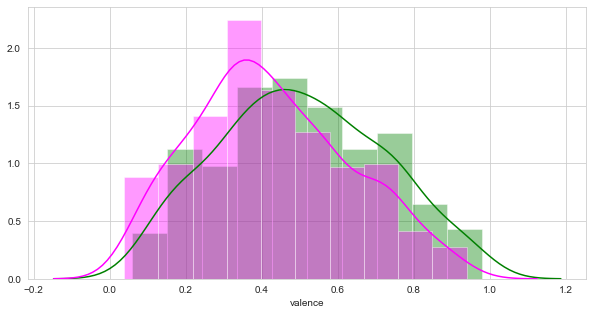

In [29]:
plt.figure(figsize=(10,5))
sns.distplot(df3['valence'], bins=10, color='green')
sns.distplot(df2['valence'], bins=10, color='magenta')

### Loudness 

The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

The loudness distribution for my top songs is skewed to the right, indicating a slight preference for louder music.

Spotify's top 300 most streamed tracks are slightly louder than my top 300. A speculative reason could be the Loudness War, referring to the trend of increasing audio levels in recorded music. Many critics believe this reduces sound quality and dynamic range of the track, apparent in pop songs where ultra-compression occurs.

<AxesSubplot:xlabel='loudness'>

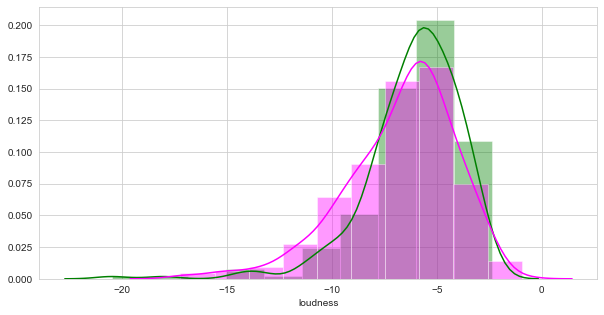

In [30]:
plt.figure(figsize=(10,5))
sns.distplot(df3['loudness'], bins=10, color='green')
sns.distplot(df2['loudness'], bins=10, color='magenta')

### Energy

A measure from 0.0 to 1.0 representing a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

My top tracks are normally distributed in terms of energy, indicating little preference for either side. I listen to a variety of music so this make sense as I'm not restricted to a particular music style.

Spotify's top most streamed generally displays higher energy tracks.

<AxesSubplot:xlabel='energy'>

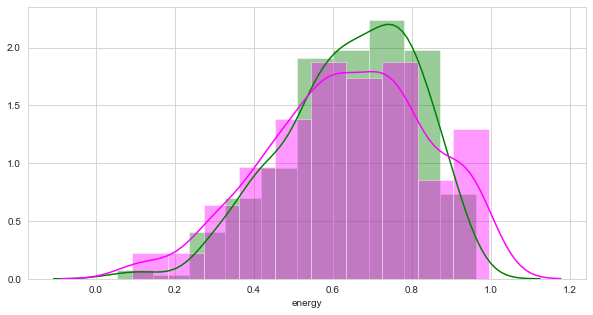

In [31]:
plt.figure(figsize=(10,5))
sns.distplot(df3['energy'], bins=10, color='green')
sns.distplot(df2['energy'], bins=10, color='magenta')

### Acousticness 

A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

Preference is shown for non-acoustic songs. 

I listen to acoustic tracks but generally prefer a fuller band setting with other instruments.

<AxesSubplot:xlabel='acousticness'>

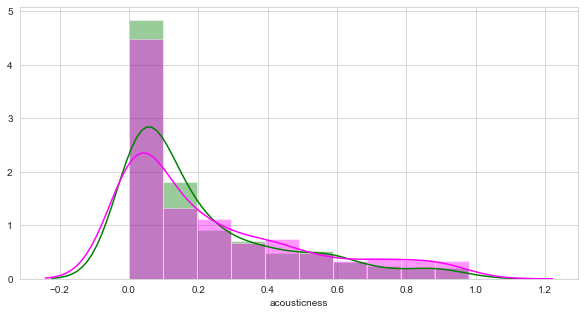

In [32]:
plt.figure(figsize=(10,5))
sns.distplot(df3['acousticness'], bins=10, color='green')
sns.distplot(df2['acousticness'], bins=10, color='magenta')

## Duration

Most of the songs seem to last in the range of about 200,000ms = 3.3 mins~. There exists outliers due to the nature of the genre. Most songs I listen to tend to fall around this range with the exception of prog-rock and instrumentals, which are usually longer in duration.

Both datasets display similar duration for the songs. Spotify's top 300 reveals that most mainstream songs generally have a similar play time, suggesting preference for radio-friendly song durations.

<AxesSubplot:xlabel='length'>

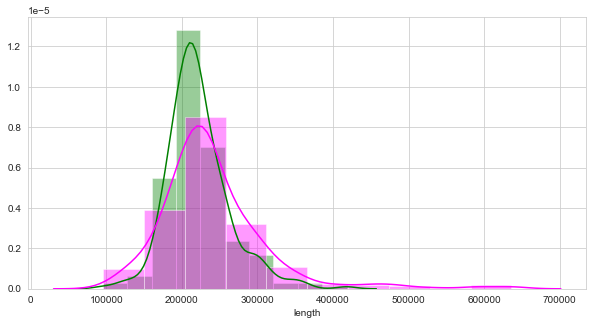

In [34]:
plt.figure(figsize=(10,5))
sns.distplot(df3['length'], bins=10, color='green')
sns.distplot(df2['length'], bins=10, color='magenta')

### Danceability

Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

Spotify's top tracks convey a higher skew towards more danceable tracks compared to mine. No surprises here.

<AxesSubplot:xlabel='danceability'>

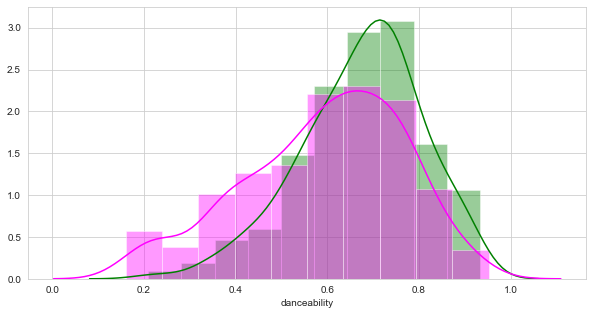

In [72]:
plt.figure(figsize=(10,5))
sns.distplot(df3['danceability'], bins=10, color='green')
sns.distplot(df2['danceability'], bins=10, color='magenta')

### Tempo

The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 

My top songs generally have a higher tempo compared to Spotify's top 300.

<AxesSubplot:xlabel='tempo'>

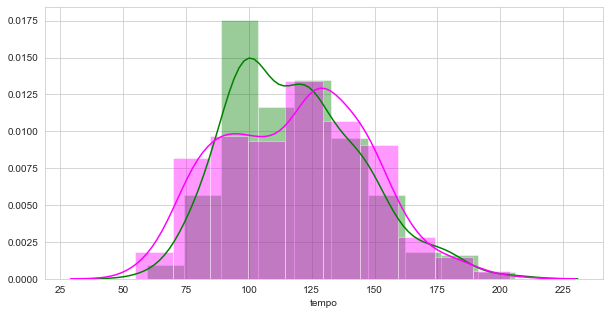

In [73]:
plt.figure(figsize=(10,5))
sns.distplot(df3['tempo'], bins=10, color='green')
sns.distplot(df2['tempo'], bins=10, color='magenta')

### Exploratory Data Analysis 

Pairplots for both datasets are plotted to determine if there is any correlation between any of the features.

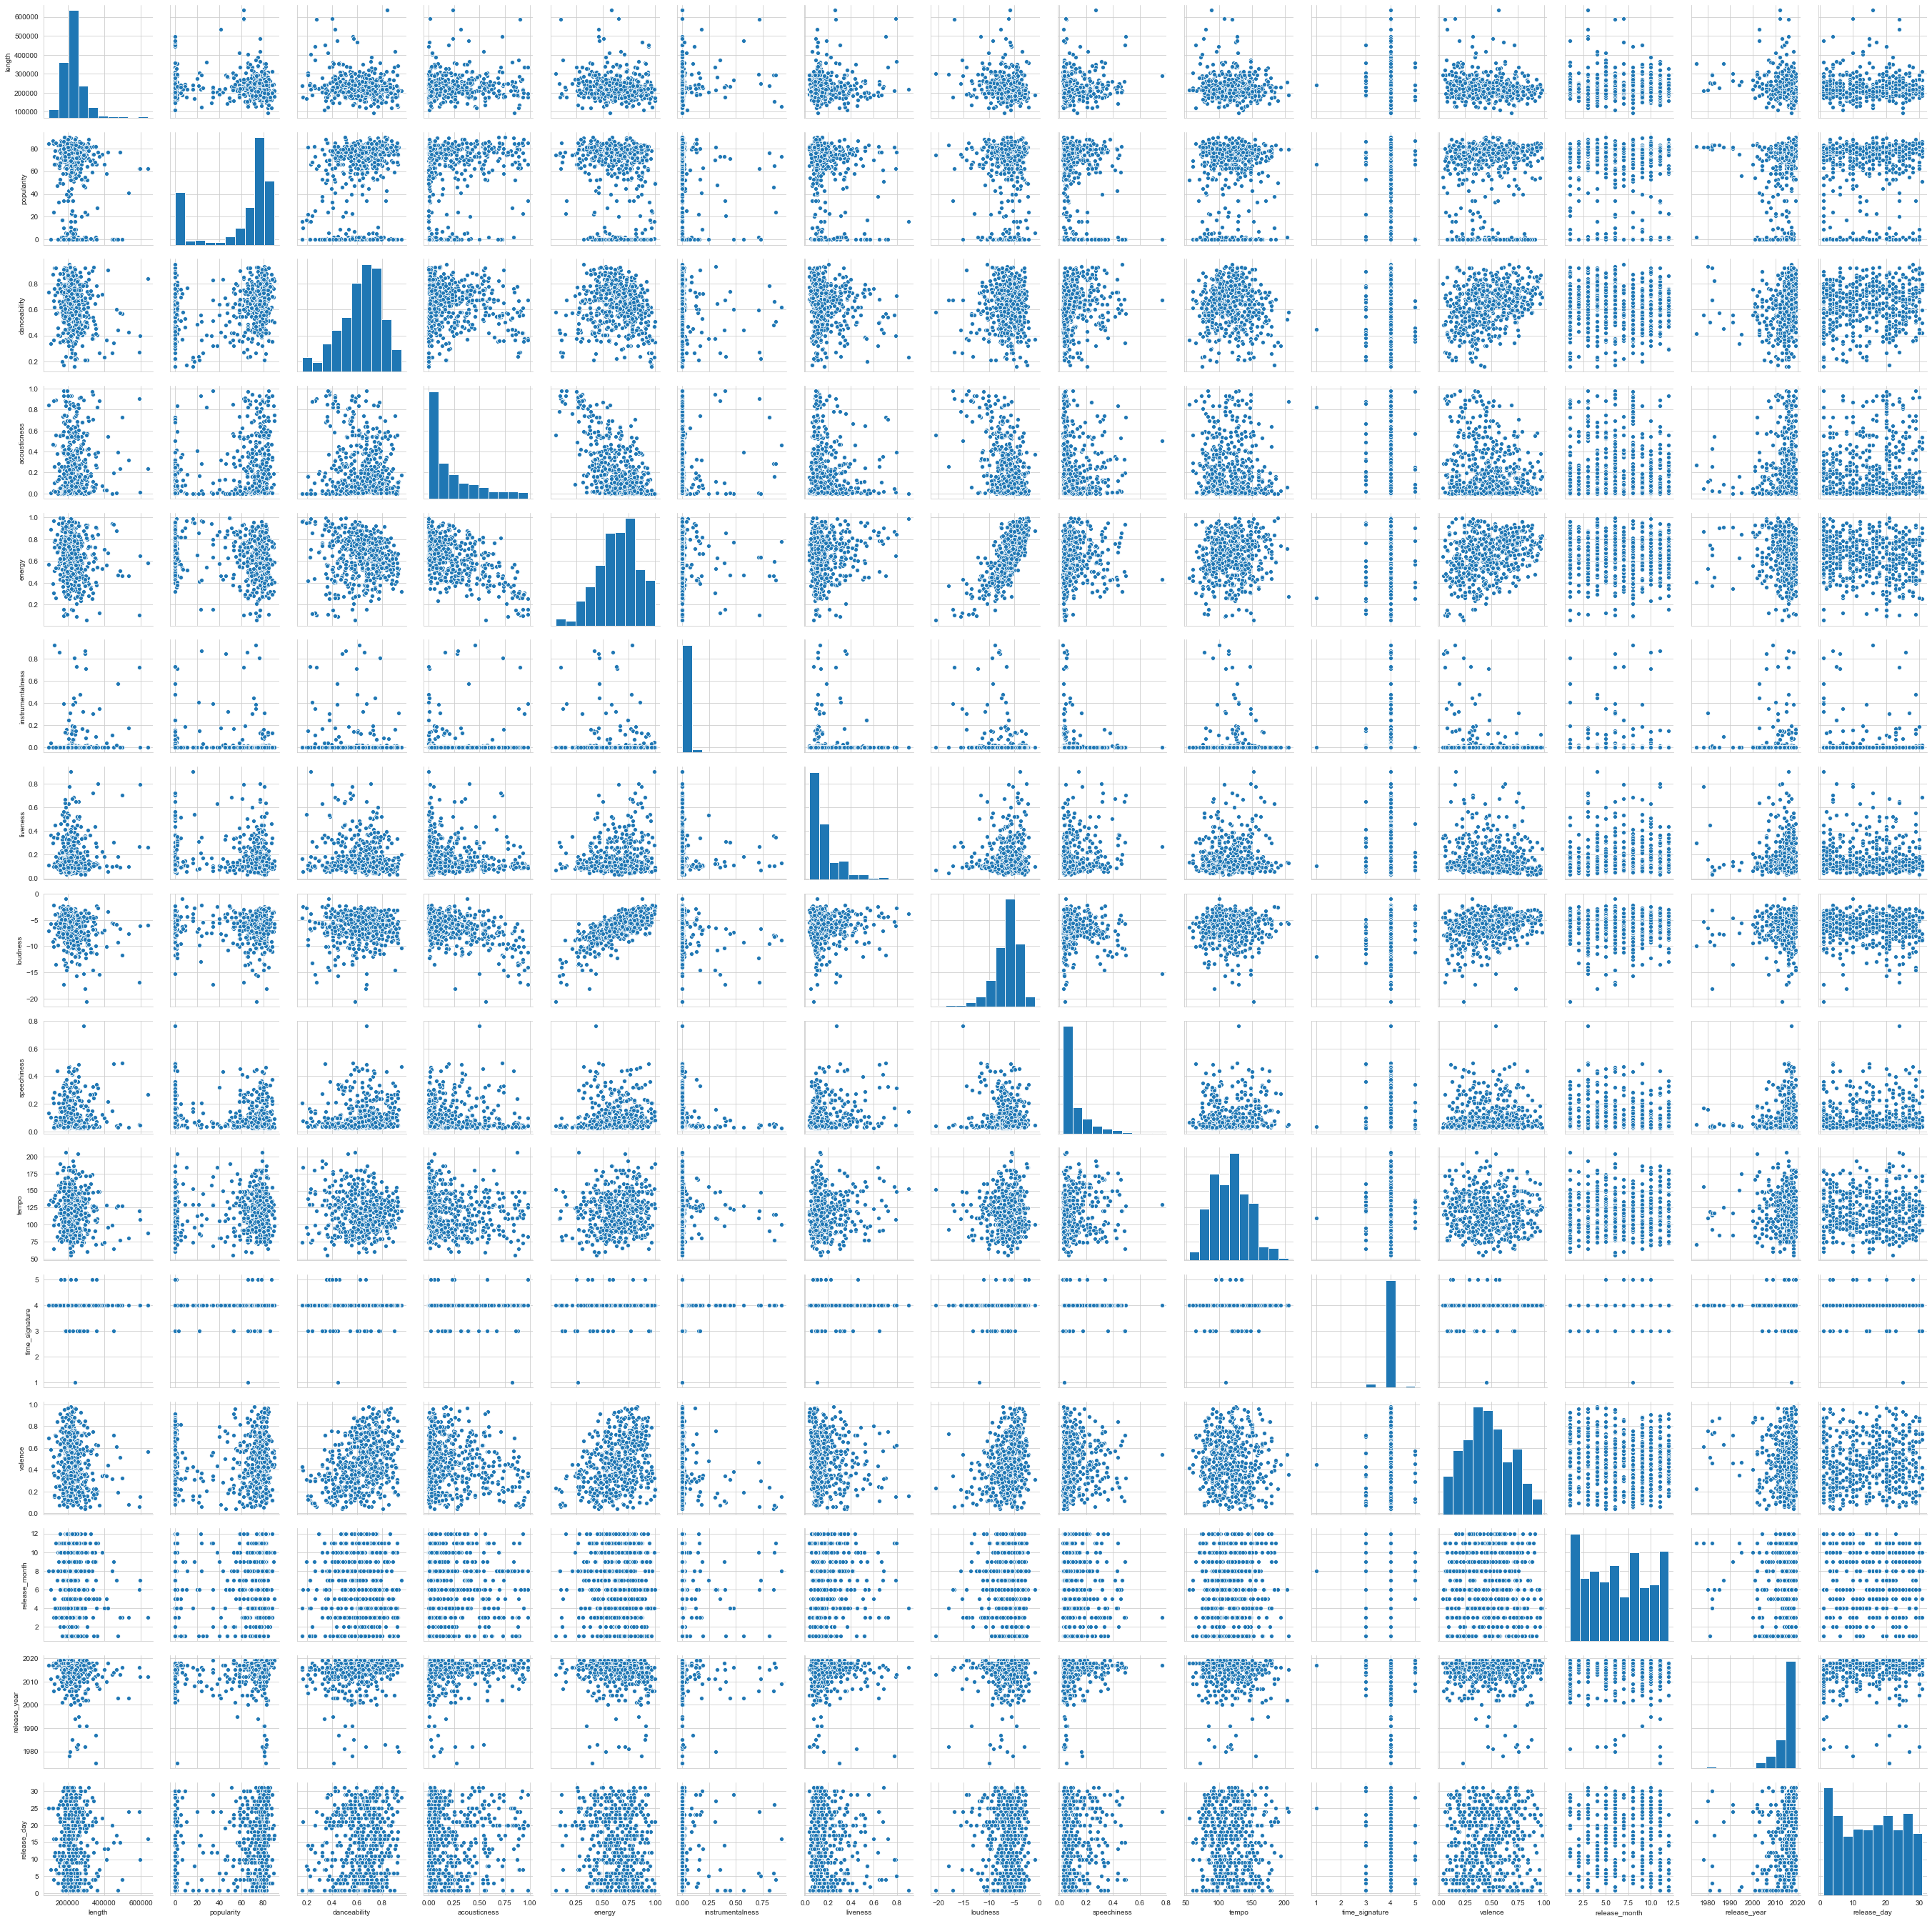

In [20]:
sns.pairplot(df)

### Correlation

We can observe from the pairplots above that there is a correlation between the loudness and the perceived energy of the song. 

The jointplots below are from both datasets and indicate a correlation between the two.

The louder the song is, the more energetic it is perceived to be. 

There is also a correlation between the "danceability" and "valence" of a track but it is not as strong.


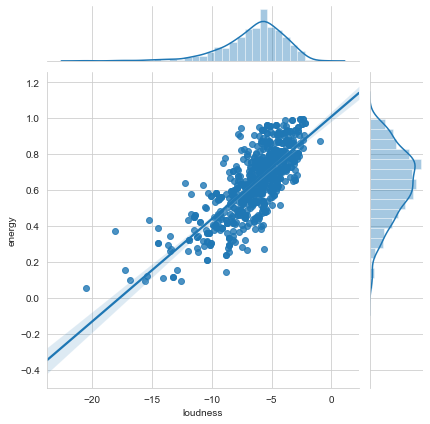

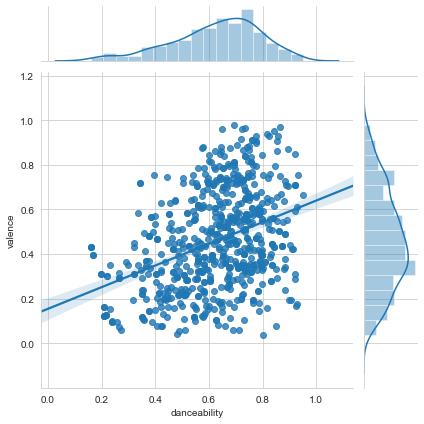

In [37]:
sns.jointplot('loudness','energy', data=df, kind='reg')
sns.jointplot('danceability','valence', data=df, kind='reg')

### Random Forests

I will utilize the Random Forests classifier to determine if the track features are sufficient to predict if a song will be in the top 300 Spotify's most streamed songs.

Firstly, the tracks are tagged with "1" or "0" depending on whether they are inside the top 300 most streamed songs on Spotify. They are split into train/test splits with sklearn based on the above mentioned "Tag" column as the dependent variable (either "1" or "0"), with the rest of the features as independent variables (dropping the non-relevant features).

I will use a train/test split of 25%/75% and subsequently print out both the confusion matrix and classification report to further analyse the classifier performance.



In [22]:
tag_list = []

for x in df['playlist'] == "Top 300 Most Streamed Songs Of All Time [Spotify]":
    if x == True:
        tag_list.append(1)
    else:
        tag_list.append(0)

df['tag'] = tag_list

In [70]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

X = df.drop(['name','album','artist','release_date','playlist','time_signature','release_year','release_month', "dayofweek","release_day",'tag','popularity'],axis=1)

y = df['tag']


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print(confusion_matrix(y_test,rfc_pred))
print("\n")
print(classification_report(y_test,rfc_pred))


[[74 25]
 [35 42]]


              precision    recall  f1-score   support

           0       0.68      0.75      0.71        99
           1       0.63      0.55      0.58        77

   micro avg       0.66      0.66      0.66       176
   macro avg       0.65      0.65      0.65       176
weighted avg       0.66      0.66      0.66       176



### Classification Report

The model achieved weighted average accuracy scores of 66% for both precision and recall.

The recall scores however, indicates that it may be easier to classify a non-top 300 most streamed song on Spotify compared to one that was indeed a top 300 most streamed song.

In conclusion, the results indicate that based on features alone, it would be possible to predict if a song would have a higher chance of entering the top 300 most streamed songs on Spotify. 

#### Things to consider:

Firstly, we do not consider the competition from other songs. This is a massive barrier to entry for songs looking to break into the top 300 from the incumbent songs.

We must also consider the behaviour of the listener. Whether the listener is someone who relistens to old songs or someone who uses the "discover" playlists curated by Spotify will impact the results.

### Precision  - What percent of your predictions were correct?

Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class, it is defined as the ratio of true positives to the sum of a true positive and false positive.
Precision:- Accuracy of positive predictions.
Precision = TP/(TP + FP)

### Recall - What percent of the positive cases did you catch?

Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.
Recall:- Fraction of positives that were correctly identified.
Recall = TP/(TP+FN)

### F1 score - What percent of positive predictions were correct?

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

## Support

Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

<AxesSubplot:xlabel='importance', ylabel='feature'>

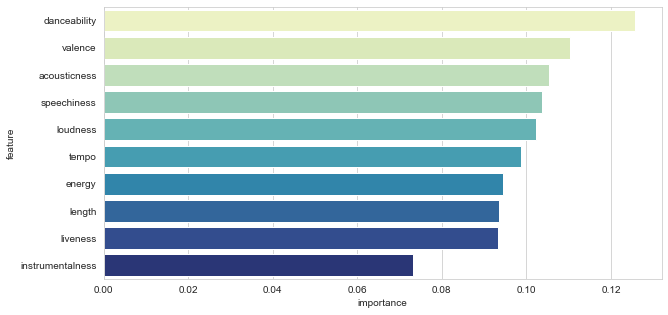

In [71]:
indices = np.argsort(rfc.feature_importances_)[::-1]

plt.figure(figsize=(10,5))

feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(X_train.shape[1]):
  feature_rank.loc[f] = [f+1,
                         X_train.columns[indices[f]],
                         rfc.feature_importances_[indices[f]]]
sns.barplot( y = 'feature', x = 'importance', data = feature_rank,palette="YlGnBu")

### Feature Importance 

Here, we plot out the feature importance. Danceability seems to be the most important feature in this case, followed by tempo. A hypothesis could be that songs that are faster and more danceable would have a higher chance of making it to the top 300. Some examples of genres that fit these attributes could be club songs/electronic dance music.


# Conclusion

I would not consider this model to be a sure indicator that the song would make it into the top 300 most streamed Spotify songs. However, it could reasonably serve as a guideline in terms of audio features for anyone looking to make a mainstream hit. 

We also have to consider the huge impact of pop culture as well as the ever-changing landscape of current music which will always impact the chances of a track breaking into the top 300 more than any of the audio features will.

